In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine
from spatial_maps.fields import (
    find_peaks, calculate_field_centers, separate_fields_by_laplace, 
    map_pass_to_unit_circle, calculate_field_centers, distance_to_edge_function, 
    in_field, compute_crossings)
from spike_statistics.core import permutation_resampling

import scipy.signal as ss
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

In [3]:
# %matplotlib notebook
%matplotlib inline

In [4]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "phase-precession"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [5]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,burst_event_ratio,bursty_spike_ratio,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.398230,0.678064,-0.466923,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,20.224859
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.138014,0.263173,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,27.897271
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.373986,0.659259,-0.572566,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,28.810794
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.087413,0.179245,-0.437492,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,9.462322
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.248771,0.463596,-0.085938,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000


In [6]:
statistics['unit_day'] = statistics.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [7]:
stim_response_action = actions['stimulus-response']
stim_response_results = pd.read_csv(stim_response_action.data_path('results'))

In [8]:
statistics = pd.merge(statistics, stim_response_results, how='left')

In [9]:
print('N cells:',statistics.shape[0])

N cells: 1284


In [10]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [11]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,p_e_peak,t_i_peak,p_i_peak,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


# Statistics about all cell-sessions

In [12]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

# Find all cells with gridness above threshold

In [13]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


## select neurons that have been characterized as a grid cell on the same day

In [14]:
once_a_gridcell = statistics[statistics.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [15]:
print("Number of gridcells", once_a_gridcell.unit_idnum.nunique())
print("Number of gridcell recordings", len(once_a_gridcell))
print("Number of animals", len(once_a_gridcell.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


# divide into stim not stim

In [16]:
baseline_i = once_a_gridcell.query('baseline and Hz11')
stimulated_11 = once_a_gridcell.query('stimulated and frequency==11 and stim_location=="ms"')

baseline_ii = once_a_gridcell.query('baseline and Hz30')
stimulated_30 = once_a_gridcell.query('stimulated and frequency==30 and stim_location=="ms"')

print("Number of gridcells in baseline i sessions", len(baseline_i))
print("Number of gridcells in stimulated 11Hz ms sessions", len(stimulated_11))

print("Number of gridcells in baseline ii sessions", len(baseline_ii))
print("Number of gridcells in stimulated 30Hz ms sessions", len(stimulated_30))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 56
Number of gridcells in stimulated 30Hz ms sessions 40


# Plotting

In [17]:
max_speed = .5 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

speed_binsize = 0.02
occupancy_threshold = 0.01

stim_mask = True
baseline_duration = 600

In [18]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, 
    stim_mask=stim_mask, baseline_duration=baseline_duration,
    occupancy_threshold=occupancy_threshold
)

In [19]:
n1 = baseline_i.sort_values('gridness', ascending=False).iloc[4]

In [20]:
from skimage import measure

In [21]:
from scipy import ndimage

In [22]:
occupancy_map = data_loader.occupancy(n1.action)

In [23]:
xbins, ybins = data_loader.spatial_bins
spike_map = sp.maps._spike_map(
                data_loader.tracking(n1.action)['x'],
                data_loader.tracking(n1.action)['y'],
                data_loader.tracking(n1.action)['t'],
                data_loader.spike_train(n1.action, n1.channel_group, n1.unit_name),
                xbins, ybins)

In [24]:
rate_map = spike_map / occupancy_map

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [25]:
rate_map_ = np.where(((occupancy_map < 0.01) & (occupancy_map > 0.0)), np.nan, rate_map)

In [26]:
def interpolate2D_nan(array, method='nearest'):
    from scipy import interpolate
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    # xnew, ynew = np.mgrid[0:50:200j, 0:50:200j]

    return interpolate.griddata(
        (x1, y1), newarr.ravel(), (xx, yy),
         method=method, fill_value=0)

In [27]:
rate_map_interp = interpolate2D_nan(rate_map_, 'linear')

In [28]:
rate_map_zero_pad = np.where(np.isnan(rate_map_), 0, rate_map_)

In [29]:
rate_map_smooth = data_loader.rate_map(
    n1.action, n1.channel_group, n1.unit_name, smoothing=smoothing_low)

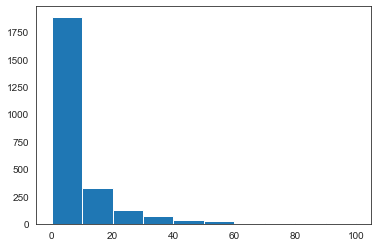

In [30]:
plt.hist(rate_map_interp.ravel());

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/image.py:401: RuntimeWarning: invalid value encountered in double_scalars
  newmin = vmid - dv * fact
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


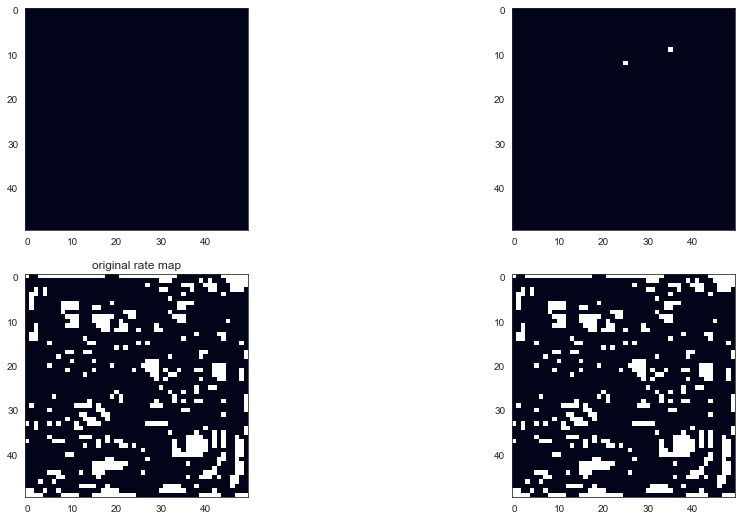

In [31]:
fig, axs = plt.subplots(2,2, figsize=(16,9))
axs = axs.ravel()
axs[0].imshow(rate_map_interp, vmax=np.nanmax(rate_map))

axs[1].imshow(rate_map_zero_pad, vmax=np.nanmax(rate_map))

axs[2].imshow(rate_map, vmax=np.nanmax(rate_map))
axs[2].set_title('original rate map')

axs[3].imshow(rate_map_, vmax=np.nanmax(rate_map))

[]

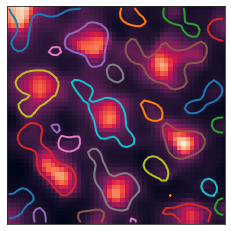

In [32]:
fig, ax = plt.subplots()
rate_map_interp = (rate_map_interp - rate_map_interp.mean()) / rate_map_interp.std()
#     rate_map = 
contours = measure.find_contours(ndimage.gaussian_laplace(rate_map_interp, 2), 0)

ax.imshow(rate_map_smooth)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [33]:
ndimage.gaussian_laplace(rate_map_interp, 2)

array([[-0.01216933, -0.18477022, -0.37888423, ...,  0.04704205,
         0.05195794,  0.05533037],
       [ 0.06242098, -0.10035802, -0.29154648, ...,  0.04329449,
         0.0464793 ,  0.04945571],
       [ 0.16629132,  0.01574545, -0.17432701, ...,  0.02523981,
         0.02084019,  0.02039963],
       ...,
       [-0.06153596, -0.04609071, -0.0206462 , ...,  0.01719365,
        -0.00154032, -0.03521869],
       [-0.01061842, -0.00319638,  0.01103386, ...,  0.05387841,
         0.06069851,  0.04339642],
       [ 0.03565926,  0.03613616,  0.04012575, ...,  0.08972131,
         0.11210749,  0.10577201]])

[]

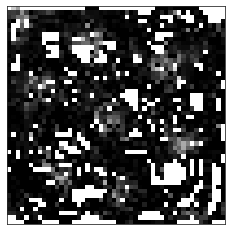

In [34]:
fig, ax = plt.subplots()

contours = measure.find_contours(ndimage.gaussian_laplace(rate_map, .9), 0)

ax.imshow(rate_map, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

In [35]:
from skimage.morphology import reconstruction

In [36]:
rate_map_norm = (rate_map_smooth - rate_map_smooth.mean()) / rate_map_smooth.std()

In [37]:
h = 2.5
seed = rate_map_norm - h
dilated = reconstruction(seed, rate_map_norm, method='dilation')
rate_map_reconstructed = rate_map_norm - dilated

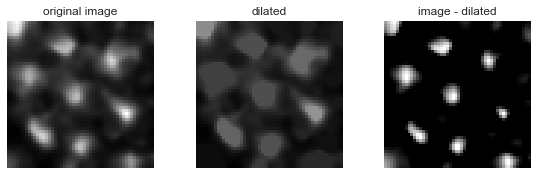

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(rate_map_norm, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=rate_map_norm.min(), vmax=rate_map_norm.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(rate_map_reconstructed, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [48]:
# l = ndimage.laplace(rate_map_reconstructed)
l = ndimage.gaussian_laplace(rate_map_reconstructed, 3)

In [49]:
l[l > 0] = 0

In [50]:
fields, field_count = ndimage.label(l)

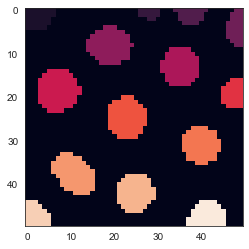

In [51]:
plt.imshow(fields)

In [44]:
fields

array([[ 1,  1,  1, ...,  0,  0,  4],
       [ 1,  1,  1, ...,  0,  4,  4],
       [ 1,  1,  1, ...,  4,  4,  4],
       ...,
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0]], dtype=int32)

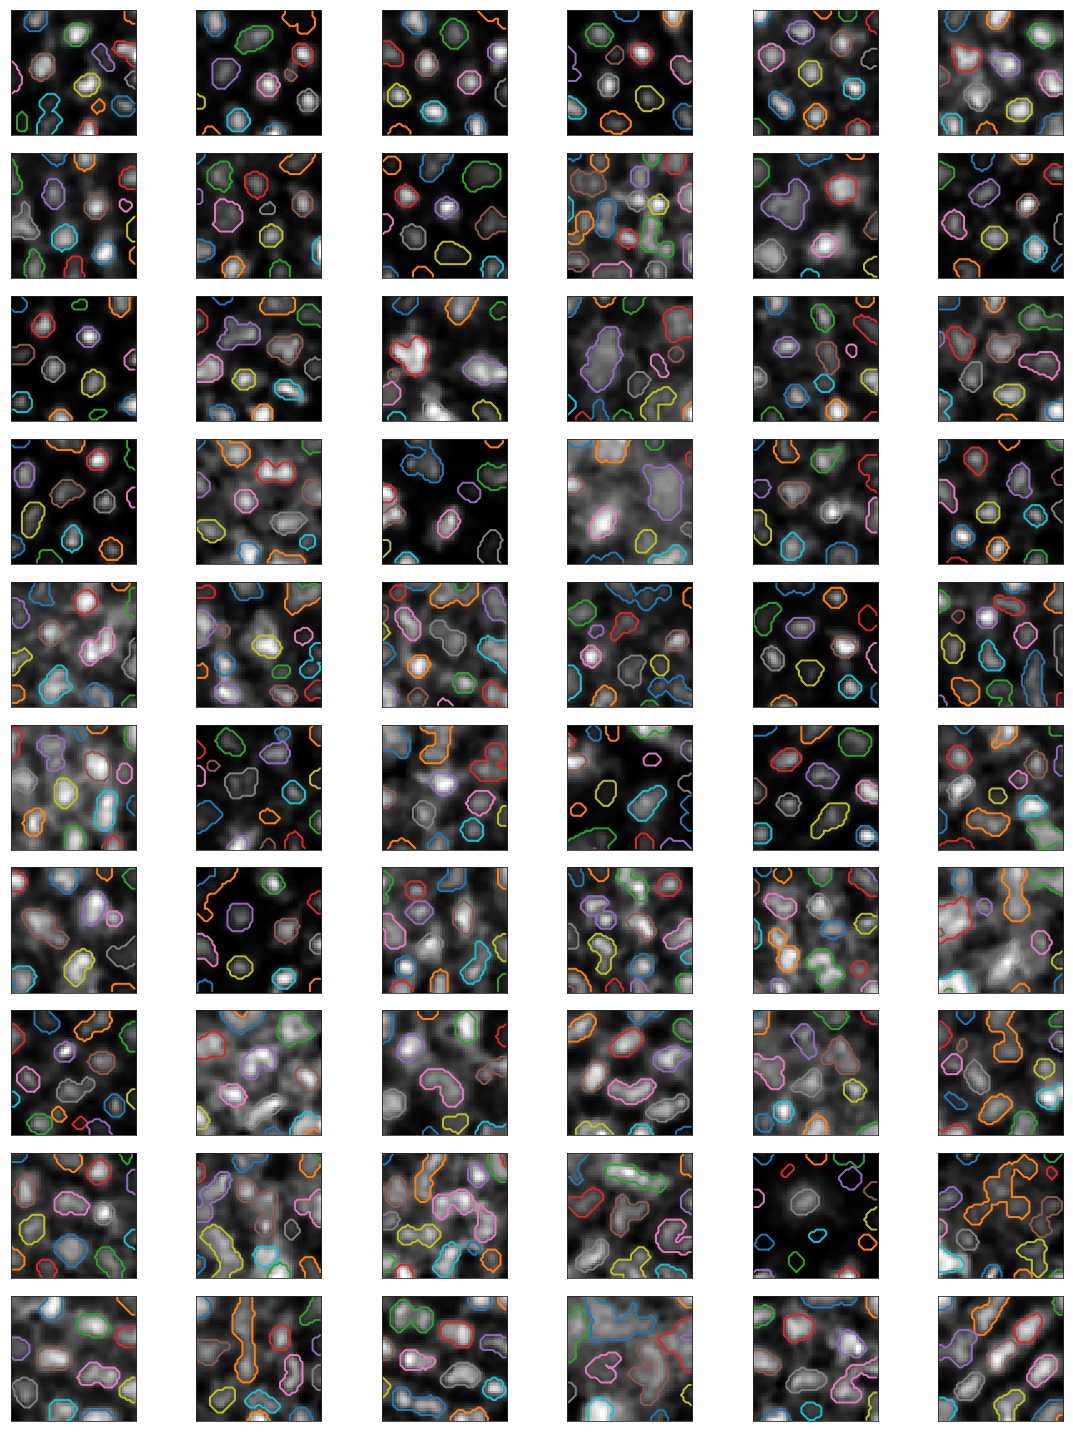

In [46]:
nrow = 10
ncol = 6
fig, axs = plt.subplots(nrow, ncol, figsize=(16,nrow*2))
axs = axs.ravel()
df_iter = baseline_i.sort_values('gridness', ascending=False).iloc[:len(axs),:].itertuples()
for n1, ax in zip(df_iter, axs):
    
    rate_map = data_loader.rate_map(n1.action, n1.channel_group, n1.unit_name, smoothing=smoothing_low)
    fields_laplace = sp.fields.separate_fields_by_dilation(rate_map, minimum_field_area=9)
    contours = measure.find_contours(fields_laplace, .1)

# Find contours at a constant value of 0.8
#     rate_map = (rate_map - rate_map.mean()) / rate_map.std()
# #     rate_map = 
#     contours = measure.find_contours(ndimage.gaussian_laplace(rate_map, 3), 0)

    # Display the image and plot all contours found
    ax.imshow(rate_map, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

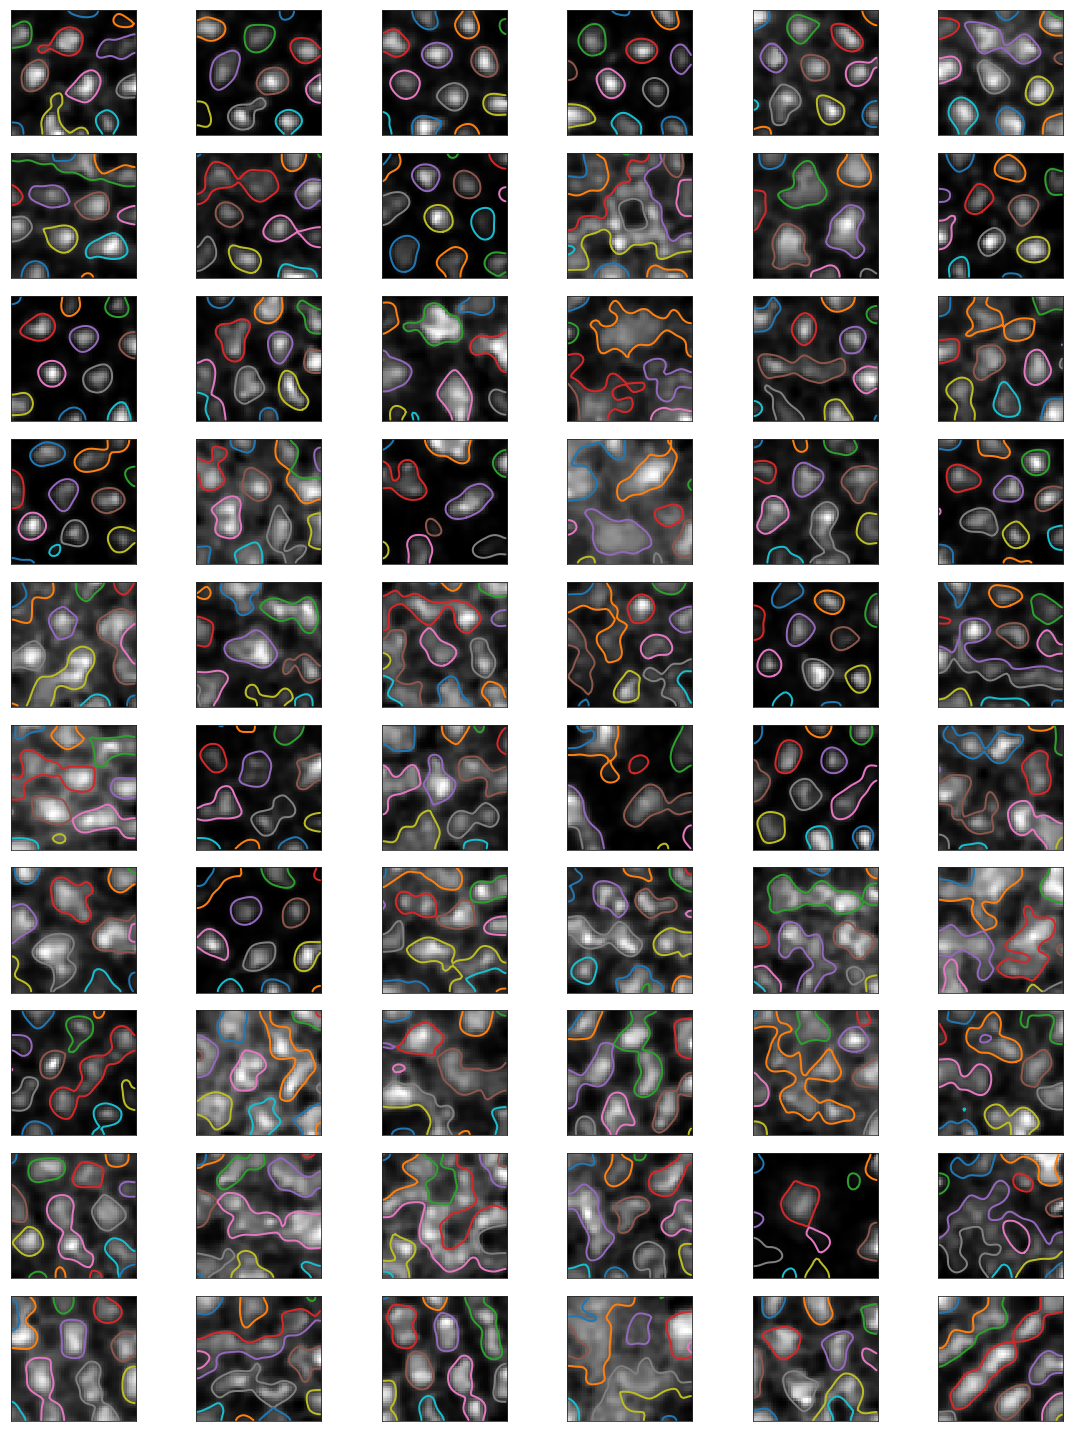

In [388]:
nrow = 10
ncol = 6
fig, axs = plt.subplots(nrow, ncol, figsize=(16,nrow*2))
axs = axs.ravel()
df_iter = baseline_i.sort_values('gridness', ascending=False).iloc[:len(axs),:].itertuples()
for n1, ax in zip(df_iter, axs):
    
    rate_map = data_loader.rate_map(n1.action, n1.channel_group, n1.unit_name, smoothing=smoothing_low)
#     fields_laplace = sp.separate_fields_by_laplace(rate_map, threshold=0.0)
#     contours = measure.find_contours(fields_laplace, .1)

# Find contours at a constant value of 0.8
    rate_map = (rate_map - rate_map.mean()) / rate_map.std()
#     rate_map = 
    contours = measure.find_contours(ndimage.gaussian_laplace(rate_map, 3), 0)

    # Display the image and plot all contours found
    ax.imshow(rate_map, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

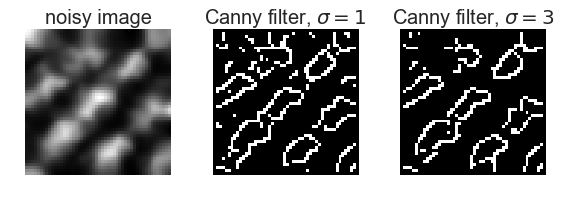

In [454]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# im = rate_map_interp
im = rate_map_smooth

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=.5, low_threshold=30)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()